# Scrapping with Selenium
The objetive of this notebook is to **scrape tourist accommodation data** from a webpage and to make a **data-pipeline** to store the scrapped data in a **database**.


## Selenium Installation:

* install selenium library with pip

        pip install selenium

* [download and install chrome](https://www.google.com/chrome/)
* [download chrome driver binary](https://sites.google.com/a/chromium.org/chromedriver/downloads) must be the right one for the chrome installed version
        
        
[check this article](https://www.scrapingbee.com/blog/selenium-python/)

## Scrapping Target
**"cabañas de turismo en san rafael"**, in  www.alquilerargentina.com
* Price
* Number of people allowed
* Date


this will yield:
* inflation of the average price per person

### Code:
Scrappe the target web and get lists for price, number_of_people, date_of_consult

In [1]:
URL = 'https://www.alquilerargentina.com/Mendoza/San-Rafael/?pag='
DRIVER_PATH = '/home/user/chromedriver'

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

options = Options()
options.headless = True
options.add_argument("--window-size=1920,1200")

driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)

In [2]:
URL = 'https://www.alquilerargentina.com/Mendoza/San-Rafael/?pag='
pag = 1
cont=0
tot=0
driver.get(URL+str(pag))  #read first page

codes = []
num_ppls = []
prices = []

there_is_more = True
while there_is_more:   # mientras no sea la ultima corre la rutina
    try:
        if pag==1:      #first page estimate number of registries to be needed
            n_registries_expected = driver.find_elements_by_class_name('BreadcumListado__lista')[0].text
            n_registries_expected = n_registries_expected.replace('(',' ')
            n_registries_expected =[int(s) for s in n_registries_expected.split() if s.isdigit()][0]
            n_registries_expected = 2*n_registries_expected
            codes = [None]*n_registries_expected
            num_ppls = [None]*n_registries_expected
            prices = [None]*n_registries_expected
            
            
        
        anuncios = driver.find_elements_by_class_name('AnuncioCardListado')
        for anuncio in anuncios:
            ref= anuncio.find_elements_by_css_selector(".AnuncioCardListado__descripcion [href]")
            ref =  ref[0].get_attribute('href').replace('https://www.alquilerargentina.com/alojamientos/','')
            ref = ref.split('-')[0]
            personas = anuncio.find_element_by_class_name('AnuncioCardListado__texto').text
            personas =[int(s) for s in personas.split() if s.isdigit()][0]

            precio = anuncio.find_element_by_class_name('CardPrecio__precio-real').text.replace('$','').replace('.','')

            ppp = round(int(precio)/int(personas),0)

            #print(ref, personas, precio)
            codes[cont] = ref
            num_ppls[cont] = personas
            prices[cont] = precio
            
            tot +=ppp
            cont+=1
        # read next page
        pag +=1
        driver.get(URL+str(pag))
        print(URL+str(pag))
    except:
        print("exceción saliendo del loop")
        there_is_more = False

print(tot/cont)


codes = list(filter(None.__ne__, codes))
num_ppls = list(filter(None.__ne__, num_ppls))
prices = list(filter(None.__ne__, prices))
print(codes, num_ppls, prices)

https://www.alquilerargentina.com/Mendoza/San-Rafael/?pag=2
https://www.alquilerargentina.com/Mendoza/San-Rafael/?pag=3
https://www.alquilerargentina.com/Mendoza/San-Rafael/?pag=4
https://www.alquilerargentina.com/Mendoza/San-Rafael/?pag=5
https://www.alquilerargentina.com/Mendoza/San-Rafael/?pag=6
exceción saliendo del loop
831.7300613496933
['lh49', 'wx68', 'pe37', 'rj95', 'jq61', 'fa01', 'gz98', 'na80', 'ge72', 'aa88', 'xj62', 'po21', 'na80', 'fa01', 'wa09', 'nd30', 'hs70', 'ka04', 'ua23', 'de20', 'th60', 'la44', 'zj76', 'xs91', 'pe37', 'ud09', 'xm36', 'rp65', 'lp50', 'rh64', 'oh43', 'xz34', 'ua23', 'jg66', 'qd73', 'cx50', 'xm05', 'hk19', 'ka04', 'lp51', 'kf20', 'kt40', 'rj95', 'zr74', 'jz40', 'rd56', 'cx50', 'pu87', 'kg56', 'sr96', 'tc39', 'nc22', 'xm35', 'wq44', 'tq78', 'lh49', 'rg63', 'sl52', 'wf71', 'hk19', 'ta95', 'jm70', 'jg66', 'cq81', 'kt40', 'ta95', 'rp65', 'po21', 'ud09', 'nc22', 'lu76', 'qd73', 'hn47', 'gz98', 'aa64', 'ht01', 'ep53', 'no15', 'cw96', 'nl99', 'jq61', 'mh18'

## Data Structure
Evaluating different models for the data storage...

### SQL
 
Simple model,everything in one table, n_persons is repeated in each row unnecessarily.
 
id |code| date_o  | n_persons| price
---|----|---------|----------|---
 1 |wa70| 7-8-2021|4         | 3800
 2 |jj96| 7-8-2021|6         | 3900
...| ...|   ...   |   ...    | ...
 n |wa70| 8-9-2022|6         | 6800
 m |jj96| 8-9-2022|6         | 7800 

 
Query for every row with som_code  :

```sql
     SELECT date_o, price FROM myTable WHERE code=='wa70'
 ```

### SQL with relationship

id |code| n_persons | price
---|----|-----------|-------
 1 |wa70| 4         | 3800
 2 |jj96| 6         | 3900


id |code_foreight_key| date_o  | price
---|-----------------|---------|-----
 1 |1                | 7-8-2021| 3800
 2 |2                | 7-8-2021| 3900
...|      ...        |   ...   | ...
 n |1                | 8-9-2022| 6800
 m |2                | 8-9-2022| 7800 


This make sense when there is aditional info about each code, like complete url, more details,etc

### NoSQL - MongoDB
 
* Each code has it own's document.
* Date and price are appended each week. 
* Maximum size of 16mb per document is OK for many years of work.
 

 
 
 ```json
 {
 code      : 'wa70',
 n_persons : 4,
 date_o    : { date_1, ...,  date_n},
 price     : {price_1, ..., price_n},
 }

```

### Removing duplicate data

In the event that three consecutive records, for the same code, are equal, the middle one will be deleted.

this can be done:
* ~~at the time of adding the new data: (would make the save much slower with many intermediate queries)~~
* after adding the new data (once a week)
* running a regular rearrangement function (check ALL the duplicated records not just three)

## Data pipeline to DataBase
### SQLalchemy to SQL



In [7]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, DateTime
from datetime import datetime

from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker


# sqlite3 example, used only for intial testing =============================
SQLALCHEMY_DATABASE_URL = "sqlite:///sql_app.db"
engine = create_engine(SQLALCHEMY_DATABASE_URL,
                       connect_args={"check_same_thread": False}
                       )


SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

# ===========================================================================
Base = declarative_base()


class Registry(Base):
    __tablename__ = 'registries'
    id = Column(Integer(), primary_key=True)
    code = Column(String(6), nullable=False)
    price = Column(Integer(), nullable=False)
    num_p = Column(Integer(), nullable=False)
    date_o = Column(DateTime(), default=datetime.now())

    def __str__(self):
        info = self.code + ',p:' + str(self.num_p) +\
            ',$:' + str(self.price) + '-' + str(self.date_o)
        return info

# ===========================================================================
Session = sessionmaker(engine)
session = Session()


# next 2 lines are will delete all previous data, run only for a fresh start
# Base.metadata.drop_all(engine)      # WARNING!! THIS WILL DELETE THE DB
# Base.metadata.create_all(engine)    

# ===========================================================================
import time
t0 = time.time()

for i in range (0, len(codes)):
    new_registry = Registry(code=codes[i],
                            price=prices[i],
                            num_p=num_ppls[i])
    session.add(new_registry)
    session.commit()
    session.refresh(new_registry)

print(str(len(codes))+ ' registries in '+str(time.time() - t0) + " secs")

163 registries in 0.5003886222839355 secs


[check this discussion about multiple insertions](https://stackoverflow.com/questions/3659142/bulk-insert-with-sqlalchemy-orm)


In [ ]:
import time
import sqlite3

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,  create_engine
from sqlalchemy.orm import scoped_session, sessionmaker

Base = declarative_base()
DBSession = scoped_session(sessionmaker())
engine = None

def test_sqlalchemy_core(n=100000):
    init_sqlalchemy()
    t0 = time.time()
    engine.execute(
        Customer.__table__.insert(),
        [{"name": 'NAME ' + str(i)} for i in xrange(n)]
    )
    print(
        "SQLAlchemy Core: Total time for " + str(n) +
        " records " + str(time.time() - t0) + " secs")

##  Data pipeline to MongoDB

    pip install pymongo

[check this article](https://realpython.com/web-scraping-with-scrapy-and-mongodb)

In [ ]:
import pymongo

from scrapy.conf import settings


class MongoDBPipeline(object):

    def __init__(self):
        connection = pymongo.MongoClient(
            settings['MONGODB_SERVER'],
            settings['MONGODB_PORT']
        )
        db = connection[settings['MONGODB_DB']]
        self.collection = db[settings['MONGODB_COLLECTION']]


In [ ]:
import pymongo

from scrapy.conf import settings
from scrapy.exceptions import DropItem
from scrapy import log


class MongoDBPipeline(object):

    def __init__(self):
        connection = pymongo.MongoClient(
            settings['MONGODB_SERVER'],
            settings['MONGODB_PORT']
        )
        db = connection[settings['MONGODB_DB']]
        self.collection = db[settings['MONGODB_COLLECTION']]

    def process_item(self, item, spider):
        valid = True
        for data in item:
            if not data:
                valid = False
                raise DropItem("Missing {0}!".format(data))
        if valid:
            self.collection.insert(dict(item))
            log.msg("Question added to MongoDB database!",
                    level=log.DEBUG, spider=spider)
        return item


## Data pipeline to MySQL
[check this article](https://www.zyte.com/blog/price-intelligence-with-python-scrapy-sql-pandas/)

```python
def process_item(self, item, spider):
    sql = "INSERT INTO table (field1, field2, field3) VALUES (%s, %s, %s)"
    self.cursor.execute(sql,(
        item.get("field1"),
        item.get("field2"),
        item.get("field3"),)
    )
    self.conn.commit()
    return item
```

## Bulk insert in PostgreSQL


[check this article](https://www.postgresqltutorial.com/postgresql-insert-multiple-rows/)

SQL code:

```sql
INSERT INTO 
    links (url, name)
VALUES
    ('https://www.google.com','Google'),
    ('https://www.yahoo.com','Yahoo'),
    ('https://www.bing.com','Bing');
```


### Using [Psycopg3](https://www.psycopg.org/) to connect with PostreSQL


## Data analysis  from DB

TO-DO 

Read data from db to pandas dataframe, and initial analytics.
* get averages for every week, grouping by number of people


Make graphics in matplotlib, plotly and check some JS options for a future frontend client

In [1]:
import sqlite3
import pandas as pd
# Create your connection.
cnx = sqlite3.connect('sql_app.db')

df = pd.read_sql_query("SELECT * FROM registries", cnx)

In [2]:
df['ppp']=(df['price']/df['num_p']).astype(int)
df.head()

,id,code,price,num_p,date_o,ppp
0,1,lh49,7040,7,2021-08-23 21:45:53.517376,1005
1,2,wx68,3500,5,2021-08-23 21:45:53.517376,700
2,3,pe37,5000,4,2021-08-23 21:45:53.517376,1250
3,4,rj95,5500,9,2021-08-23 21:45:53.517376,611
4,5,jq61,2500,4,2021-08-23 21:45:53.517376,625


In [3]:
a=df.groupby(['num_p']).mean().drop(columns=['id'])
a['price/person']=a.price/a.index
a['size of the group']=df.groupby(['num_p']).size()
#del df
a.head()

,price,ppp,price/person,size of the group
num_p,,,,
2,4900.000000,2450.000000,2450.000000,1
3,2800.000000,933.000000,933.333333,3
4,3604.736842,901.157895,901.184211,19
5,4783.478261,956.695652,956.695652,46
6,4595.423729,765.576271,765.903955,59


#### Mean Price per person per  day for different capacity places

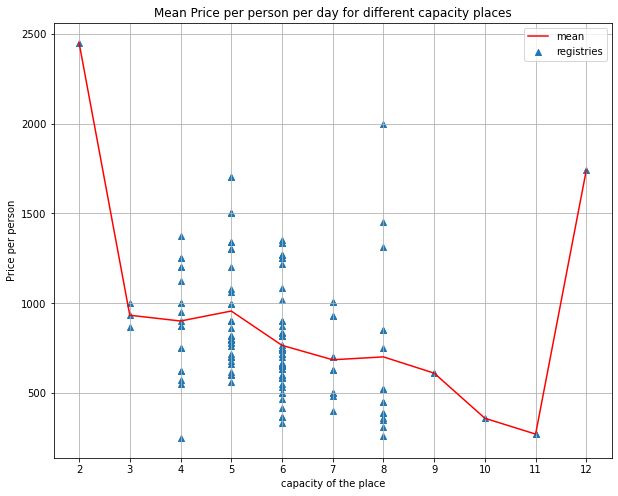

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(a.index, a['price/person'], c='red',label = "mean")
plt.xlabel('x - axis')
plt.ylabel('y - axis')

plt.title('Mean Price per person per day for different capacity places')
plt.scatter(df.num_p, df.ppp, label='registries', marker ='^')

plt.xlabel("capacity of the place")
plt.ylabel("Price per person")
plt.xticks(np.arange(min(a.index), max(a.index)+1, 1.0))
plt.legend()
plt.grid()
plt.show()